### 評価関数
- 2つのセンサ値をとる

In [1]:
import numpy as np
import sys

class NeuralNetMLP(object):
   
    """入力
       n_hidden:隠れユニットの数
       l2:正規化パラメータλ(L2が0のときは正規化なし)
        epochs:学習回数
       eta:学習率
       shuffle:循環を避けるための変数(boolでtrueのときトレーニングデータをシャッフル)
       minibatch_size:ミニバッチ当たりのトレーニングサンプルの個数
       seed:重みとシャッフルを初期化するための乱数シード
        """ 

    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    ###################################
    ######outputでえらぶニューロン#####
    ##################################
    def _onehot(self, y, n_classes):
        """ラベルをone-hot表現にエンコード
        入力
            y:目的変数の値（shape=(n_classes, n_labels)）
        出力     
        onehot 
        """   
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):#int型に変換
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """フォワードプロパゲーションのステップを計算"""

        # step 1: 隠れ層の入力     
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: 隠れ層の活性化関数
        a_h = self._sigmoid(z_h)

        # step 3: 出力層の総入力
        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: 出力層の活性化関数
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """コスト関数
        
        パラメータ
        ----------
        y_enc : one-hot表現にエンコードされたクラスラベル
        output : 出力層の活性化関数(フォワードプロパゲーション)

       返り値
        ---------
        cost :正規化されたコスト
        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))
        
        ####ロジスティック関数のコスト関数#####
        ######対数尤度関数#自然対数を最小化するほうが簡単#######
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
              
        return cost
    
    ########クラスラベル予測###########
    def predict(self, X):
        """
      　入力
        -----------
        X :元の特徴量が設定された入力層
        
       出力
        ----------
        y_pred :予測されたクラスラベル
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)#出力層で一番大きい値をとるものを予測に適応
        return y_pred
    
    #########重みの学習##########
    def fit(self, X_train, y_train_enc):
        ", X_valid, y_valid):"
        """
        入力
        -----------
        X_train : 元の特徴量が設定された入力層
        y_train :目的値のクラスラベル
        X_valid :トレーニング時の検証に使用するサンプル特徴量
        y_valid : トレーニング時の検証に使用するサンプルラベル

        出力
        ----------
        self
        """
        n_output = 4#np.unique(y_train_enc).shape[0]  # クラスラベルの個数が出力の数
        n_features = X_train.shape[1]

        ########################
        ######重みの初期化######
        ########################

        # 入力層→隠れ層の重み
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,size=(n_features, self.n_hidden))

        # 隠れ層→出力層の重み
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,size=(self.n_hidden, n_output))
        """
        epoch_strlen = len(str(self.epochs))  # 書式設定#表示するもの
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        """
        #y_train_enc = self._onehot(y_train, n_output)#y_train:目的変数の値, n_output:クラスラベルの個数
        
        # エポック数だけトレーニングを繰り返す
        for i in range(self.epochs):

            #インデックス
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)
                
            #ミニバッチの反復処理(イテレーション)
            for start_idx in range(0, indices.shape[0] - self.minibatch_size +1, 
                                   self.minibatch_size):
                #ミニバッチ学習の範囲の移動
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                
                ##################################
                ### フォワードプロパゲーション###
                #################################
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##############################
                ### バックプロパゲーション ###
                #############################
                
                ####誤差行列(コスト関数の微分)####
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                
                ####シグモイド関数の微分#####
                # [n_classlabels, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                ####誤差行列(コスト関数の入力z微分)#####
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)
                
                #####偏微分係数(コスト関数の重みw微分)##########
                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                #####偏微分係数(コスト関数の重みw微分)##########
                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # 正則化
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # バイアスは正則化しない
                
                #####接続重み修正########勾配に対して反対方向
                self.w_h -= self.eta * delta_w_h
                #######バイアス修正######
                self.b_h -= self.eta * delta_b_h

                # 正則化
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  #バイアスは正則化しない
                
                #####接続重み修正########
                self.w_out -= self.eta * delta_w_out
                #######バイアス修正######
                self.b_out -= self.eta * delta_b_out
                
            """
            ##############
            #### 評価 ####
            ##############
            #学習中のそれぞれのエポックごとに評価を行う
            #入力1つずつに対して
            z_h, a_h, z_out, a_out = self._forward(X_train)
            #コスト関数
            cost = self._compute_cost(y_enc = y_train_enc, output = a_out)

            y_train_pred = self.predict(X_train)#trainingデータの予測
            y_valid_pred = self.predict(X_valid)#testデータの予測
            
            #トレーニングの正解率
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            #検証の正解率
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            """


        return self

In [2]:
import pandas as pd
import math

######################################################
########## 入力値：ランダムウォークの設定 ############
######################################################

#ランダムウォークのデータ
df_sensor = pd.read_csv('2dimention_sensor_data_2.csv')
length = len(df_sensor)

X_sensor = np.array(df_sensor.loc[:,'front':'left'])
#X_sensor = X_sensor.astype(int)

action = np.array(np.zeros(length))
action = np.array(df_sensor.loc[:,'action'])

#各行の最小センサ値の列名
minimum_kind = df_sensor.loc[:,'front':'left'].idxmin(axis = 1)
#教師の初期化
#teacher = np.array(np.zeros((length,4)))
teacher = np.zeros((length,4))

for i in range(1, length):
    
    min_fir_before = sorted(X_sensor[i-1])[0]
    min_sec_before = sorted(X_sensor[i-1])[1]
    #print(min_fir_before)
    senor_min_before = math.sqrt(min_fir_before**2 + min_sec_before**2)
    
    min_fir_now = sorted(X_sensor[i])[0]
    min_sec_now = sorted(X_sensor[i])[1]
    
    senor_min_now = math.sqrt(min_fir_now**2 + min_sec_now**2)
    
    if action[i] == -1:
        action[i] = 0
    elif action[i] == 1:
        action[i] = 1
    elif action[i] == 3:
        action[i] = 2
    elif action[i] == -3:
        action[i] = 3
    
    #前に動いたとき
    if action[i] == 1:
        #正解
        if senor_min_now - senor_min_before > 0: # and X_sensor[i][minimum_num] >=8:
            teacher[i] = (1,0,0,0)
        #不正解
        else: 
            teacher[i] = (0,1,1,1)
            
    #後に動いたとき
    if action[i] == 0:
        #正解
        if senor_min_now - senor_min_before > 0: # and X_sensor[i][minimum_num] >=8:
            teacher[i] = (0,1,0,0)
        #不正解
        else: 
            teacher[i] = (1,0,1,1)
    
    #右に進んだとき
    elif action[i] == 2:
        if senor_min_now - senor_min_before > 0: #and X_sensor[i][minimum_num - 2]>=8:
            teacher[i] = (0,0,1,0)
        #不正解
        else:
            teacher[i] = (1,1,0,1)
  
    #左に進んだとき
    elif action[i] == 3:
        #正解
        if senor_min_now - senor_min_before > 0: #and X_sensor[i][minimum_num + 2] >= 8:
            teacher[i] = (0,0,0,1)
        #不正解
        else: 
            teacher[i] = (1,1,1,0)

X_sensor = np.delete(X_sensor, 0,0)
teacher = np.delete(teacher, 0,0)
teacher = teacher.astype(int)
action = np.delete(action, 0,0)

print(action)
print(teacher)

[0 0 0 3 0 2 1 3 2 0 1 3 2 1 0 2 0 2 0 2 3 0 3 0 0 3 2 1 0 0 0 3 3 3 1 3 3
 1 2 0 0 1 1 3 3 1 2 0 3 0 3 1 2 2 2 0 3 0 1 3 2 1 0 2 0 2 0]
[[1 0 1 1]
 [1 0 1 1]
 [1 0 1 1]
 [0 0 0 1]
 [0 1 0 0]
 [1 1 0 1]
 [1 0 0 0]
 [1 1 1 0]
 [0 0 1 0]
 [1 0 1 1]
 [1 0 0 0]
 [1 1 1 0]
 [1 1 0 1]
 [0 1 1 1]
 [1 0 1 1]
 [0 0 1 0]
 [1 0 1 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 1 0 1]
 [0 0 0 1]
 [1 0 1 1]
 [1 1 1 0]
 [1 0 1 1]
 [1 0 1 1]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 1 1]
 [1 0 1 1]
 [1 0 1 1]
 [0 0 0 1]
 [1 1 1 0]
 [1 1 1 0]
 [0 1 1 1]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 1 1]
 [1 0 1 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 1 1 1]
 [1 1 0 1]
 [0 1 0 0]
 [1 1 1 0]
 [0 1 0 0]
 [1 1 1 0]
 [0 1 1 1]
 [1 1 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 1 1]
 [1 0 0 0]
 [1 1 1 0]
 [1 1 0 1]
 [0 1 1 1]
 [0 1 0 0]
 [1 1 0 1]
 [1 0 1 1]
 [0 0 1 0]
 [1 0 1 1]]


### ランダムウォークの学習
- 学習回数4回

In [3]:
################# インスタンス生成 ######################
nn = NeuralNetMLP(n_hidden = 100, #隠れユニットの数
                 l2 = 0.01,#正則化のλパラメータ
                 epochs = 50, #n_epochs, #トレーニング回数
                 eta = 0.0005, #学習率
                 minibatch_size = 1, 
                 shuffle = True, #各エポックでデータをシャッフルするかどうか
                 seed = 1)


################## 学習 ######################
for i in range(1):
    
    fit = nn.fit(X_train = X_sensor,#センサ値の差
          y_train_enc = teacher)#前か後ろか

#################### 予測 ####################
pre = nn.predict(X_sensor)
print(pre)

[0 0 3 1 1 0 3 1 3 3 3 1 3 3 0 2 2 1 1 1 1 2 2 2 2 3 2 2 2 2 2 3 1 2 2 2 3
 3 2 2 2 2 2 2 3 1 1 3 1 1 2 2 1 3 3 3 3 3 3 1 1 1 1 3 3 2 2]


### 逐次学習
- 学習回数：sensor_epoch 

In [4]:
import numpy as np
import serial
import time
l = 1
sensor_list_append = np.array([])
teacher_append =  np.array([])
action_append =  np.array([])
sensor_epoch  = 20
count = 0
for l in range(sensor_epoch):
    count += 1
    print(count)
    ################### センサー値取得 ####################
    # COMポート(Arduino接続)
    ser_sensor = serial.Serial('COM4',9600)#センサー
    ser_sensor.flush()
    ser_sensor.write(b"r")#センサ読み込む
    time.sleep(4)
    input_num = 4
    sensor = np.zeros((1,input_num))
    for i in range(input_num):

        #シリアル通信で受け取った情報（文字列）を改行コードがくるまで代入
        data = ser_sensor.readline().rstrip() # readline:行終端まで読み込む  rstrip:行終端コード削除　→　# \nまで読み込む(\nは削除
        data = data.decode() #対話型だとこれが必要。その情報をデコードする。
        data = float(data)
        sensor[0,i] = data

    sensor_list = np.array(sensor)#.astype(int)
    ser_sensor.close()

    ################### 予測 #######################

    pre = nn.predict(sensor_list)

    #################### 移動 #######################
    ser_motor = serial.Serial("COM3",9600)
    ser_motor.flush()
    
    #予測した値をロボットに送る
    if pre == 1: #foward
        ser_motor.write(b"1")
    elif pre == 0: #back
        ser_motor.write(b"0")#バイト型で送信
    elif pre == 2: #right
        ser_motor.write(b"2")#バイト型で送信
    elif pre == 3: #left
        ser_motor.write(b"3")#バイト型で送信
        
    data = ser_motor.readline().rstrip()
    data = data.decode()
    
    ser_motor.close()
    
    ###############################################
    ################## 逐次学習 ###################
    ###############################################

    ############## センサー値取得 #################
    next_ser_sensor = serial.Serial('COM4',9600)
    next_ser_sensor.flush()
    next_ser_sensor.write(b"r")#センサ読み込む
    
    # 初期化
    next_sensor_list = np.zeros((1,input_num))
    next_sensor_list_2 = np.zeros((1,input_num))
    
    for i in range(input_num):

        data = next_ser_sensor.readline().rstrip()
        data = data.decode()
        data = float(data)
        next_sensor_list[0,i] = data
    
    next_sensor_list = np.array(next_sensor_list)
    
    #################### ２つの最小センサの二乗平均 ###########################
    min_fir_before = np.sort(sensor_list[0])[0]
    min_sec_before = np.sort(sensor_list[0])[1]

    senor_min_before = math.sqrt(min_fir_before**2 + min_sec_before**2)
    
    min_fir_now = np.sort(next_sensor_list[0])[0]
    min_sec_now = np.sort(next_sensor_list[0])[1]

    senor_min_now = math.sqrt(min_fir_now**2 + min_sec_now**2)
    
    #教師の初期化
    t_teacher = np.array(np.zeros(4))
   
    #前に動いたとき
    if pre == 1:
        #正解
        if senor_min_now - senor_min_before > 0: # and X_sensor[i][minimum_num] >=8:
            t_teacher = (1,0,0,0)
        #不正解
        else: 
            t_teacher = (0,0.5,0.5,0.5)
            
    #後に動いたとき
    if pre == 0:
        #正解
        if senor_min_now - senor_min_before > 0: # and X_sensor[i][minimum_num] >=8:
            t_teacher = (0,1,0,0)
        #不正解
        else: 
            t_teacher= (0.5,0,0.5,0.5)
    
    #右に進んだとき
    elif pre == 2:
        if senor_min_now - senor_min_before > 0: #and X_sensor[i][minimum_num - 2]>=8:
            t_teacher = (0,0,1,0)
        #不正解
        else:
            t_teacher = (0.5,0.5,0,0.5)
  
    #左に進んだとき
    elif pre == 3:
        #正解
        if senor_min_now - senor_min_before > 0: #and X_sensor[i][minimum_num + 2] >= 8:
            t_teacher = (0,0,0,1)
        #不正解
        else: 
            t_teacher = (0.5,0.5,0.5,0)

    next_ser_sensor.close()
    
    t_teacher = np.array(t_teacher)
    t_teacher = t_teacher#.astype(int)
    
    #sensor_listをl次元の配列に順次追加していく
    sensor_list_append = np.append(sensor_list_append, sensor_list).reshape(l+1, input_num)
    
    #点数をl次元の配列に順次追加していく
    teacher_append = np.append(teacher_append, t_teacher).reshape(l+1, input_num) #, axis= 1)
    
    # SOMで可視化するactionを記録
    action_append = np.append(action_append, pre)#.reshape(l+1, 1)
    
    X_train = np.append(X_sensor, sensor_list_append, axis= 0)
    y_train = np.append(teacher, teacher_append, axis= 0)
    action = np.append(action, action_append)#, axis = 0)
    
    
    #学習
    #fit = nn.fit(X_train  ,y_train)
    fit = nn.fit(sensor_list ,t_teacher)
    
    print("sensor_list : "+str(sensor_list) + " /next_sensor_list: "+str(next_sensor_list))
    print(pre)
    print("t_teacher: "+ str(t_teacher))
    #print("next_sensor_list: "+str(next_sensor_list))


1
sensor_list : [[ 98.78  28.93 108.09  33.78]] /next_sensor_list: [[ 21.05 105.9  106.83  34.12]]
[3]
t_teacher: [0.5 0.5 0.5 0. ]
2
sensor_list : [[ 21.07 105.5  106.88  34.07]] /next_sensor_list: [[ 31.64  94.83 106.79  35.31]]
[0]
t_teacher: [0 1 0 0]
3
sensor_list : [[ 31.66  95.66 106.81  35.31]] /next_sensor_list: [[ 22.03 104.91 105.29  35.31]]
[1]
t_teacher: [0.  0.5 0.5 0.5]
4
sensor_list : [[ 21.98 104.91 105.69  34.9 ]] /next_sensor_list: [[ 32.1   94.78 105.81  35.88]]
[0]
t_teacher: [0 1 0 0]
5
sensor_list : [[ 32.1   94.47 105.36  35.86]] /next_sensor_list: [[ 22.09 105.19 107.05  35.16]]
[1]
t_teacher: [0.  0.5 0.5 0.5]
6
sensor_list : [[ 22.07 104.78 106.6   35.16]] /next_sensor_list: [[ 86.21  40.66 108.9   27.43]]
[2]
t_teacher: [0 0 1 0]
7
sensor_list : [[ 86.21  41.17 108.78  27.33]] /next_sensor_list: [[ 96.    31.38 112.78  28.57]]
[0]
t_teacher: [0.5 0.  0.5 0.5]
8
sensor_list : [[ 96.    31.38 112.79  28.57]] /next_sensor_list: [[93.21 33.98 42.83 98.1 ]]
[2]
t

ValueError: could not convert string to float: 

In [5]:
#0 0 0 3 0 2 1 3 2 0 1 3 2 1 0 2 0 2 0 2 3 0 3 0 0 3 2 1 0 0 0 3 3 3 1 3 3
# 1 2 0 0 1 1 3 3 1 2 0 3 0 3 1 2 2 2 0 3 0 1 3 2 1 0 2 0 2 0
print("action_append : "+str(action_append))

action_append : [3. 0. 1. 0. 1. 2. 0. 2. 2. 0. 3.]


In [6]:
print("action: "+str(action))

action: [0. 0. 0. 3. 0. 2. 1. 3. 2. 0. 1. 3. 2. 1. 0. 2. 0. 2. 0. 2. 3. 0. 3. 0.
 0. 3. 2. 1. 0. 0. 0. 3. 3. 3. 1. 3. 3. 1. 2. 0. 0. 1. 1. 3. 3. 1. 2. 0.
 3. 0. 3. 1. 2. 2. 2. 0. 3. 0. 1. 3. 2. 1. 0. 2. 0. 2. 0. 3. 3. 0. 3. 0.
 1. 3. 0. 1. 0. 3. 0. 1. 0. 1. 3. 0. 1. 0. 1. 2. 3. 0. 1. 0. 1. 2. 0. 3.
 0. 1. 0. 1. 2. 0. 2. 3. 0. 1. 0. 1. 2. 0. 2. 2. 3. 0. 1. 0. 1. 2. 0. 2.
 2. 0. 3. 0. 1. 0. 1. 2. 0. 2. 2. 0. 3.]


In [7]:
for i in range(length -1+count -1):
    print(action[i])

0.0
0.0
0.0
3.0
0.0
2.0
1.0
3.0
2.0
0.0
1.0
3.0
2.0
1.0
0.0
2.0
0.0
2.0
0.0
2.0
3.0
0.0
3.0
0.0
0.0
3.0
2.0
1.0
0.0
0.0
0.0
3.0
3.0
3.0
1.0
3.0
3.0
1.0
2.0
0.0
0.0
1.0
1.0
3.0
3.0
1.0
2.0
0.0
3.0
0.0
3.0
1.0
2.0
2.0
2.0
0.0
3.0
0.0
1.0
3.0
2.0
1.0
0.0
2.0
0.0
2.0
0.0
3.0
3.0
0.0
3.0
0.0
1.0
3.0
0.0
1.0
0.0
3.0


In [8]:
import os
from datetime import datetime

new_dir_path = 'data/'+ datetime.now().strftime("%Y_%m_%d_%H_%M")
os.makedirs(new_dir_path, exist_ok=True)

In [9]:
from datetime import datetime

name = '2D_learning_data'+'('+ datetime.now().strftime("%Y_%m_%d_%H_%M")+')'+'.csv'

In [10]:
import csv

#y_train = np.argmax(y_train, axis=1)
#teacher_append = np.argmax(teacher_append, axis=1)

#sensorとteacherを記録するためのcsvファイルを開く
with open(os.path.join(new_dir_path, name), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['front', 'behind','right','left','action'])

#print(y_train)
#ランダムウォークと逐次のデータ記録
for l in range(count -1  ):# length -1+count -1 
    
    #csvファイルにBMUとそのクラスを追記
    with open(os.path.join(new_dir_path, name), 'a') as f: 
        writer = csv.writer(f)
        ####禁止####writer.writerow([X_train[l, 0],X_train[l, 1],X_train[l, 2], X_train[l, 3], action[l]])
        writer.writerow([ sensor_list_append[l, 0], sensor_list_append[l, 1],sensor_list_append[l, 2],
                            sensor_list_append[l, 3], action_append[l]])

### SOM

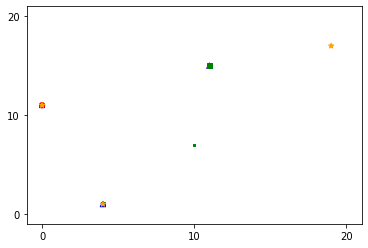

In [19]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import csv

from datetime import datetime

df = pd.read_csv(os.path.join(new_dir_path, name))
N = 20#linear size of 2D map
n_teacher = len(df) #教師データの数(学習回数)#行数
np.random.seed(1000)#シード (種) を指定することで、発生する乱数をあらかじめ固定
dimension = 4#ベクトルの次元
i = 0
def main():
    #初期ノード
    # N x N ×dimension の配列の乱数
    nodes = np.random.rand(N, N, dimension)#0.0~1.0の値で一様分布

    for x in range (N):
        for y in range(N):
            for z in range(dimension):
                M = df.iloc[:,z].max()
                m = df.iloc[:,z].min()
                #参照ベクトルを -0.5~0.5(max-min) の一様乱数とする
                nodes[x, y, z] = 1.0*(M - m) * nodes[x, y, z] + m
    
    
    #BMUとクラスを記録するためのcsvファイルを開く
    with open('bmu.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['index','bmu','classnum'])
        
    ax = plt.subplot()
    ax.set_xticks([0,N/2, N])
    ax.set_yticks([0,N/2, N])
    for df3 in range(2):
        df3 = pd.read_csv(os.path.join(new_dir_path, name))
        
        for i in range(n_teacher):
            #教師信号
            teachers = np.array(df.loc[i,'front':'left'].values) #X 
            train(nodes, teachers)
            bmu = best_matching_unit(nodes, teachers)
            y = np.array(df.loc[:, ['action']].values)
            
            #csvファイルにBMUとそのクラスを追記
            with open('bmu.csv', 'a') as f: 
                writer = csv.writer(f)
                writer.writerow([i,bmu,y[i]])
            
            df2 = pd.read_csv('bmu.csv')
            if y[i] != df2['classnum'].any:
                if y[i]==[1.]:#前
                    col='red'
                    mark = 'o'
                    l = 'front'

                elif y[i]==[0.]:#後ろ
                    col='blue'
                    mark = '^'
                    l = 'back'
                    
                elif y[i]==[2.]:#右
                    col='orange'
                    mark = '*'
                    l = 'right'
                    
                elif y[i]==[3.]:#左
                    col='green'
                    mark = 's'
                    l = 'left'
                    
                else :
                    col='black'
                    mark = 'x'
                    l = 'back'
    
            scale = 3 * df2['bmu'].value_counts() #+ 5
            plot_som = ax.scatter(bmu[0],bmu[1],color = col, marker=mark, s=scale, alpha = 1.0)
            
            #ax.scatter(bmu[0],bmu[1],color = col, marker=mark, s=scale)
            

#    for i in range(n_teacher):
        
#        if y[i] == df2['classnum'].any:
#            col = 'black'
#            mark = 'x'
#            scale = 10
#            ax.scatter(bmu[0],bmu[1],color = col, marker=mark, s=scale)
            
    plt.xlim(0-1,N+1)
    plt.ylim(0-1,N+1)
    #plt.legend()
    plt.savefig(os.path.join(new_dir_path, f'Random'+str(length)+'Sequent'+str(sensor_epoch)+'('+datetime.now().strftime("%Y_%m_%d_%H_%M")+')'+'.png'), dpi = 400, bbox_inches = 'tight')
    plt.show()
    
    
#学習   
def train(nodes, teachers):
    
    bmu = best_matching_unit(nodes, teachers)#BMU:データに対し最も似ているベクトルを持つユニットあとで定義

    for x in range(N):
        for y in range(N):
            c = np.array([x,y])
            d = np.linalg.norm(c - bmu)#ユニットの位置とBMUとの距離
            L = learning_ratio(i)#学習時間を決定するパラメータ#iはe^(-t/λ)
            S = learning_radius(i, d)#更新するユニットがどの程度BMUの近傍にいるのかを表現
            for z in range(dimension):
                nodes[x, y, z] += L * S * (teachers[z] - nodes[x, y, z])#zはがくの長さなど

                
def best_matching_unit(nodes, teacher):
    norms = np.zeros((N,N))# N×Nの２次元配列を生成
    for x in range (N):
        for y in range(N):
            for z in range(dimension):
                norms[x, y] += (nodes[x,y,z] - teacher[z])**2
    
    bmu_1 = np.argmin(norms)#１次元配列で考えたとき何番目かを返す
    bmu = np.unravel_index(bmu_1,(N,N))#argminと組み合わせることで,もとの行列の何行何列目に最小値があるのかわかる

    return bmu 

def neighbourhood(t):
    halflife = float(n_teacher/4)#時定数
    initial = float(N/4)
    return initial*np.exp(-t/halflife)

def learning_ratio(t):
    halflife=float(n_teacher/4)#時定数
    initial=0.1#Lの初期値
    return initial*np.exp(-t/halflife)

def learning_radius(t, d):
    s=neighbourhood(t)
    return np.exp(-d**2/(2*s**2))

main()

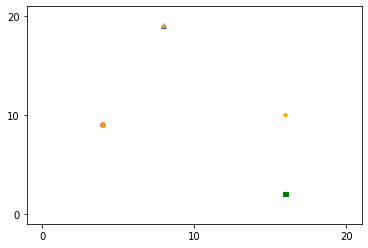

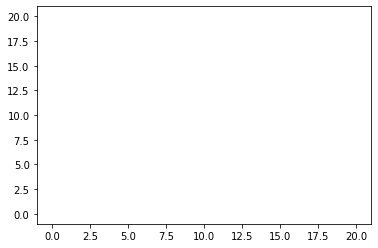

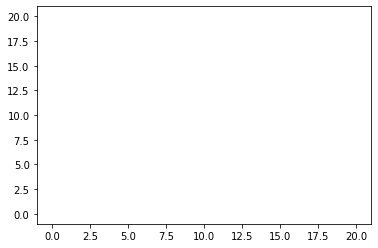

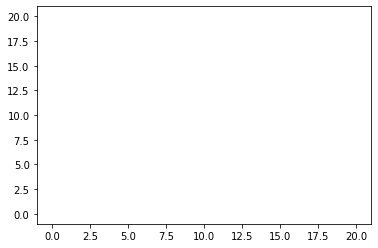

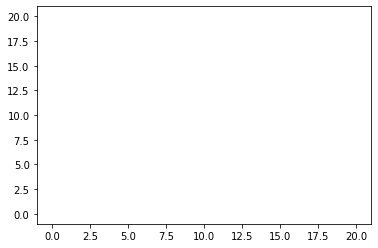

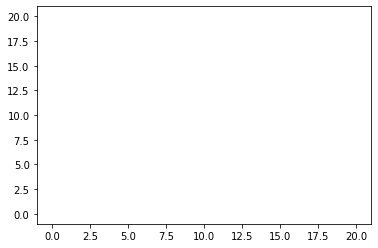

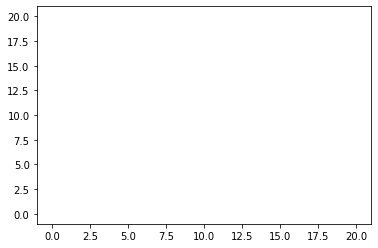

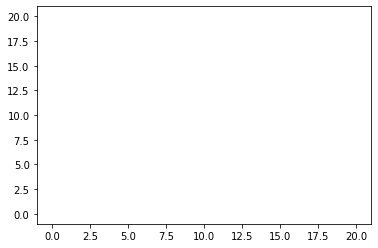

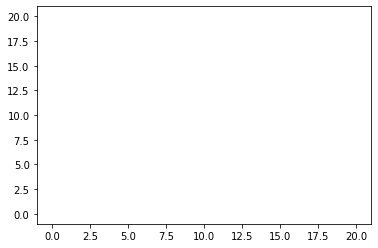

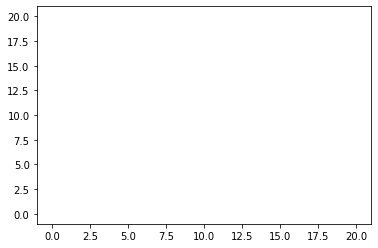

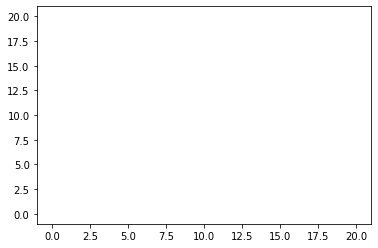

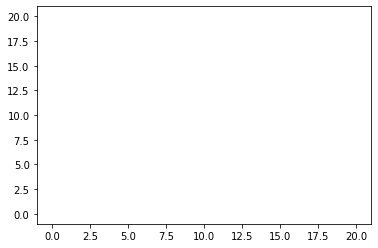

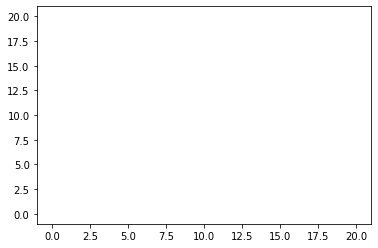

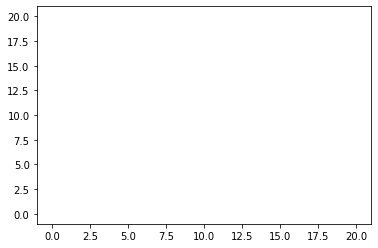

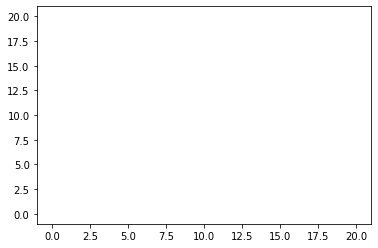

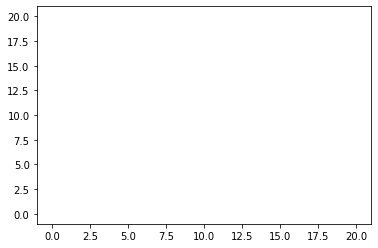

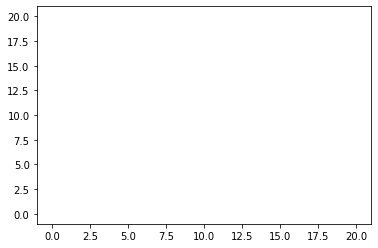

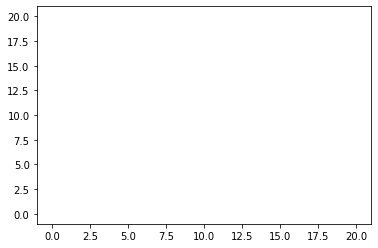

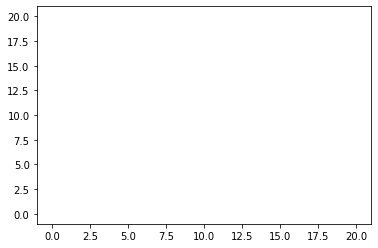

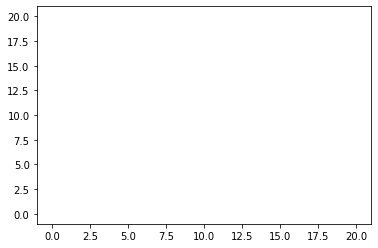

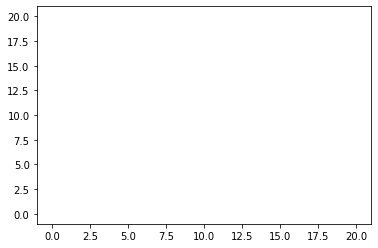

In [18]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import csv

from datetime import datetime

df = pd.read_csv(os.path.join(new_dir_path, name))
N = 20#linear size of 2D map
n_teacher = len(df) #教師データの数(学習回数)#行数
np.random.seed(1000)#シード (種) を指定することで、発生する乱数をあらかじめ固定
dimension = 4#ベクトルの次元
i = 0
def main():
    #初期ノード
    # N x N ×dimension の配列の乱数
    nodes = np.random.rand(N, N, dimension)#0.0~1.0の値で一様分布

    for x in range (N):
        for y in range(N):
            for z in range(dimension):
                M = df.iloc[:,z].max()
                m = df.iloc[:,z].min()
                #参照ベクトルを -0.5~0.5(max-min) の一様乱数とする
                nodes[x, y, z] = 0.5*(M - m) * nodes[x, y, z] + m
    
    
    #BMUとクラスを記録するためのcsvファイルを開く
    with open('bmu.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['index','bmu','classnum'])
        
    ax = plt.subplot()
    ax.set_xticks([0,N/2, N])
    ax.set_yticks([0,N/2, N])
    for df3 in range(2):
        df3 = pd.read_csv(os.path.join(new_dir_path, name))
        
        for i in range(n_teacher):
            #教師信号
            teachers = np.array(df.loc[i,'front':'left'].values) #X 
            train(nodes, teachers)
            bmu = best_matching_unit(nodes, teachers)
            y = np.array(df.loc[:, ['action']].values)
            
            #csvファイルにBMUとそのクラスを追記
            with open('bmu.csv', 'a') as f: 
                writer = csv.writer(f)
                writer.writerow([i,bmu,y[i]])
            
            df2 = pd.read_csv('bmu.csv')
            if y[i] != df2['classnum'].any:
                if y[i]==[1.]:#前
                    col='red'
                    mark = 'o'
                    l = 'front'

                elif y[i]==[0.]:#後ろ
                    col='blue'
                    mark = '^'
                    l = 'back'
                    
                elif y[i]==[2.]:#右
                    col='orange'
                    mark = '*'
                    l = 'right'
                    
                elif y[i]==[3.]:#左
                    col='green'
                    mark = 's'
                    l = 'left'
                    
                else :
                    col='black'
                    mark = 'x'
                    l = 'back'
    
            scale = 3 * df2['bmu'].value_counts() #+ 5
            plot_som = ax.scatter(bmu[0],bmu[1],color = col, marker=mark, s=scale, alpha = 1.0)
            
            #ax.scatter(bmu[0],bmu[1],color = col, marker=mark, s=scale)
            
            if i%(n_teacher/3):
                for i in range(n_teacher):
                    #教師信号
                    teachers = np.array(df.loc[i,'front':'left'].values) #X 
                    train(nodes, teachers)
                    bmu = best_matching_unit(nodes, teachers)
                    y = np.array(df.loc[:, ['action']].values)

                    #csvファイルにBMUとそのクラスを追記
                    with open('bmu.csv', 'a') as f: 
                        writer = csv.writer(f)
                        writer.writerow([i,bmu,y[i]])

                    df2 = pd.read_csv('bmu.csv')
                    if y[i] != df2['classnum'].any:
                        if y[i]==[1.]:#前
                            col='red'
                            mark = 'o'
                            l = 'front'

                        elif y[i]==[0.]:#後ろ
                            col='blue'
                            mark = '^'
                            l = 'back'

                        elif y[i]==[2.]:#右
                            col='orange'
                            mark = '*'
                            l = 'right'

                        elif y[i]==[3.]:#左
                            col='green'
                            mark = 's'
                            l = 'left'

                        else :#後ろ
                            col='black'
                            mark = 'x'
                            l = 'back'

                    scale = 3 * df2['bmu'].value_counts() #+ 5
                    plot_som = ax.scatter(bmu[0],bmu[1],color = col, marker=mark, s=scale, alpha = 1.0)

                plt.xlim(0-1,N+1)
                plt.ylim(0-1,N+1)
                #plt.legend()
                plt.savefig(os.path.join(new_dir_path, f'Random'+str(length)+'Sequent'+str(sensor_epoch)+'('+datetime.now().strftime("%Y_%m_%d_%H_%M")+')'+'.png'), dpi = 400, bbox_inches = 'tight')
                plt.show()
#    for i in range(n_teacher):
        
#        if y[i] == df2['classnum'].any:
#            col = 'black'
#            mark = 'x'
#            scale = 10
#            ax.scatter(bmu[0],bmu[1],color = col, marker=mark, s=scale)
            
    plt.xlim(0-1,N+1)
    plt.ylim(0-1,N+1)
    #plt.legend()
    plt.savefig(os.path.join(new_dir_path, f'Random'+str(length)+'Sequent'+str(sensor_epoch)+'('+datetime.now().strftime("%Y_%m_%d_%H_%M")+')'+'.png'), dpi = 400, bbox_inches = 'tight')
    plt.show()
    
    
#学習   
def train(nodes, teachers):
    
    bmu = best_matching_unit(nodes, teachers)#BMU:データに対し最も似ているベクトルを持つユニットあとで定義

    for x in range(N):
        for y in range(N):
            c = np.array([x,y])
            d = np.linalg.norm(c - bmu)#ユニットの位置とBMUとの距離
            L = learning_ratio(i)#学習時間を決定するパラメータ#iはe^(-t/λ)
            S = learning_radius(i, d)#更新するユニットがどの程度BMUの近傍にいるのかを表現
            for z in range(dimension):
                nodes[x, y, z] += L * S * (teachers[z] - nodes[x, y, z])#zはがくの長さなど

                
def best_matching_unit(nodes, teacher):
    norms = np.zeros((N,N))# N×Nの２次元配列を生成
    for x in range (N):
        for y in range(N):
            for z in range(dimension):
                norms[x, y] += (nodes[x,y,z] - teacher[z])**2
    
    bmu_1 = np.argmin(norms)#１次元配列で考えたとき何番目かを返す
    bmu = np.unravel_index(bmu_1,(N,N))#argminと組み合わせることで,もとの行列の何行何列目に最小値があるのかわかる

    return bmu 

def neighbourhood(t):
    halflife = float(n_teacher/4)#時定数
    initial = float(N/4)
    return initial*np.exp(-t/halflife)

def learning_ratio(t):
    halflife=float(n_teacher/4)#時定数
    initial=0.1#Lの初期値
    return initial*np.exp(-t/halflife)

def learning_radius(t, d):
    s=neighbourhood(t)
    return np.exp(-d**2/(2*s**2))

main()